The data used in this notebook is era5 monthly mean air temp with height over the SA-CPRCM domain for the year 2001 https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels-monthly-means?tab=overview

In [14]:
import iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import iris.plot as iplt
import datetime
import shutil
from pathlib import Path
import trackpy
from iris.time import PartialDateTime
import cartopy.crs as ccrs
import xarray as xr
import netCDF4 as nc
import scipy
from scipy import ndimage
from scipy.ndimage import label, generate_binary_structure

#import packages that output memory usage:
#from sys import getsizeof

import tobac #tobac package cloned from https://github.com/tobac-project/tobac.git

import warnings
warnings.filterwarnings('ignore')

In [15]:
filename_obs = '/project/cssp_brazil/mcs_tracking_HG/tropopause_temp/era5_air_temp_w_height.nc'

obs_airtemp = xr.open_dataset(filename_obs)

In [16]:
obs_airtemp = obs_airtemp.t

In [17]:
obs_airtemp

<xarray.DataArray 't' (time: 12, level: 37, latitude: 221, longitude: 241)>
[23647884 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -90.0 -89.75 -89.5 ... -30.5 -30.25 -30.0
  * latitude   (latitude) float32 15.0 14.75 14.5 14.25 ... -39.5 -39.75 -40.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2001-12-01
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

188.41376


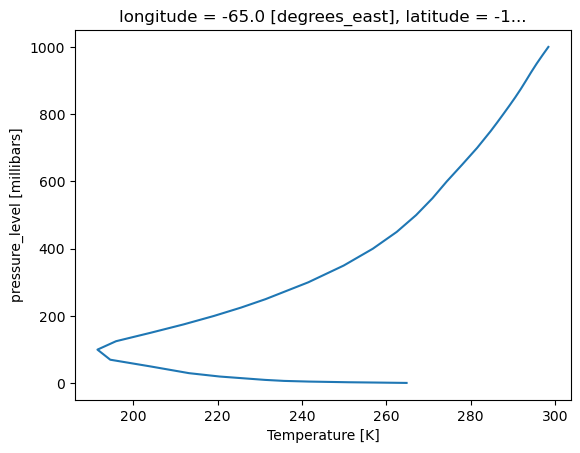

In [18]:
obs_airtemp[0,:,100, 100].plot(y='level')
trop_temp = obs_airtemp.where(obs_airtemp == obs_airtemp.min(), drop=True).squeeze().data # calculates the minimum air temperature in the vertical profile (proxy for tropopause temp) over all lats and lons at a specific timestep
print(trop_temp)

In [19]:
obs_airtemp

<xarray.DataArray 't' (time: 12, level: 37, latitude: 221, longitude: 241)>
array([[[[262.27777, ..., 262.13107],
         ...,
         [265.49292, ..., 265.50903]],

        ...,

        [[296.2362 , ..., 293.94427],
         ...,
         [287.42633, ..., 288.50342]]],


       ...,


       [[[258.58136, ..., 258.33444],
         ...,
         [266.7006 , ..., 267.0155 ]],

        ...,

        [[297.96097, ..., 296.99838],
         ...,
         [286.92358, ..., 287.38696]]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -90.0 -89.75 -89.5 ... -30.5 -30.25 -30.0
  * latitude   (latitude) float32 15.0 14.75 14.5 14.25 ... -39.5 -39.75 -40.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2001-12-01
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

**Finding the zonal mean, latitudinal mean *for whole domain* (1 value of temperature for every level each month)**

In [20]:
dy = obs_airtemp.groupby('time').mean('longitude') ##zonal mean at each time and height

In [21]:
dy

<xarray.DataArray 't' (time: 12, level: 37, latitude: 221)>
array([[[262.22818, 262.38528, 262.54147, ..., 265.2347 , 265.34872,
         265.46274],
        [259.5051 , 259.43088, 259.35583, ..., 266.94034, 267.03333,
         267.12646],
        [252.00655, 251.92625, 251.84706, ..., 262.44067, 262.5347 ,
         262.6286 ],
        ...,
        [292.36053, 292.43423, 292.5079 , ..., 288.55673, 288.3778 ,
         288.1895 ],
        [294.2583 , 294.33752, 294.413  , ..., 289.5876 , 289.38947,
         289.1839 ],
        [296.3125 , 296.39   , 296.46597, ..., 290.6912 , 290.4597 ,
         290.2254 ]],

       [[262.67957, 262.7929 , 262.90607, ..., 260.7777 , 260.87878,
         260.98093],
        [262.56595, 262.57065, 262.57492, ..., 262.76718, 262.8167 ,
         262.86664],
        [256.12466, 256.02173, 255.91766, ..., 258.23   , 258.27283,
         258.31604],
...
        [294.88028, 294.94275, 295.01154, ..., 283.8819 , 283.75064,
         283.61267],
        [296.60678, 296.66183, 296.71893, ..., 285.3055 , 285.15988,
         285.0072 ],
        [298.65387, 298.70648, 298.76517, ..., 286.80374, 286.6324 ,
         286.4545 ]],

       [[258.55948, 258.56342, 258.56644, ..., 266.6092 , 266.70844,
         266.80798],
        [256.81454, 256.85907, 256.90384, ..., 267.13226, 267.22495,
         267.31793],
        [250.53047, 250.53311, 250.53514, ..., 261.45468, 261.5549 ,
         261.65506],
        ...,
        [294.372  , 294.44632, 294.51755, ..., 286.48676, 286.34302,
         286.18246],
        [296.0345 , 296.1152 , 296.18716, ..., 287.75223, 287.6027 ,
         287.43854],
        [298.07898, 298.15723, 298.2308 , ..., 289.21317, 289.05264,
         288.8748 ]]], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 15.0 14.75 14.5 14.25 ... -39.5 -39.75 -40.0
  * level     (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time      (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2001-12-01
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

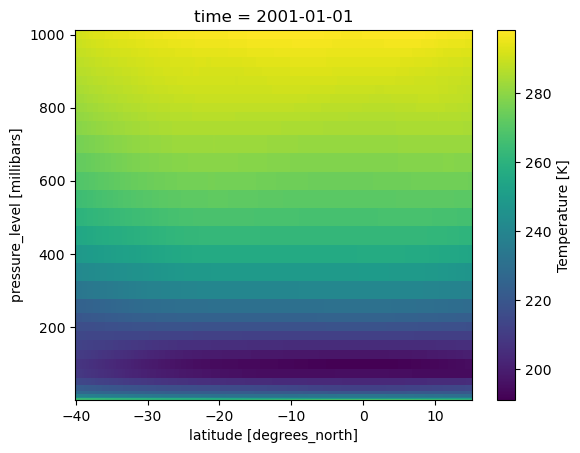

In [22]:
dy.isel(time=0).plot(y='level')

In [23]:
dz = dy.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

In [29]:
## LOOP TO FIND THE TROPOAUSE TEMP FOR EACH MONTH ##

trop_temp = []

for month in np.arange(0,13):
    subset = dz.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    print(min)
    trop_temp.append(float(min))


195.28645
194.8638
195.34857
196.2358
197.34549
199.19095
200.43205
200.62376
200.39911
198.17285
196.19205
195.94891


IndexError: index 12 is out of bounds for axis 0 with size 12

In [30]:
trop_temp

[195.2864532470703,
 194.86380004882812,
 195.34857177734375,
 196.2357940673828,
 197.34548950195312,
 199.19094848632812,
 200.4320526123047,
 200.62376403808594,
 200.39910888671875,
 198.1728515625,
 196.19204711914062,
 195.94891357421875]

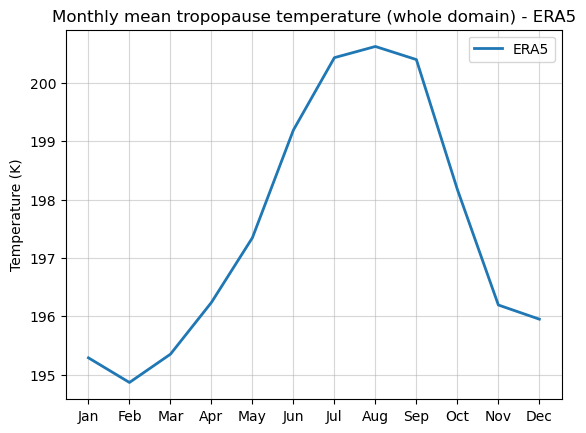

In [31]:
plt.plot(trop_temp, label='ERA5', linewidth=2)
plt.title('Monthly mean tropopause temperature (whole domain) - ERA5')
plt.xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Temperature (K)')
plt.legend(loc='best')
plt.grid(alpha=0.5)

**The same but split into tropics and subtropics...**

In [32]:
obs_airtemp

<xarray.DataArray 't' (time: 12, level: 37, latitude: 221, longitude: 241)>
array([[[[262.27777, ..., 262.13107],
         ...,
         [265.49292, ..., 265.50903]],

        ...,

        [[296.2362 , ..., 293.94427],
         ...,
         [287.42633, ..., 288.50342]]],


       ...,


       [[[258.58136, ..., 258.33444],
         ...,
         [266.7006 , ..., 267.0155 ]],

        ...,

        [[297.96097, ..., 296.99838],
         ...,
         [286.92358, ..., 287.38696]]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -90.0 -89.75 -89.5 ... -30.5 -30.25 -30.0
  * latitude   (latitude) float32 15.0 14.75 14.5 14.25 ... -39.5 -39.75 -40.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2001-01-01 2001-02-01 ... 2001-12-01
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature

In [33]:
tropics = obs_airtemp[:,:,:121,:] ## Subsetting for tropics (15N - 20S)
subtropics = obs_airtemp[:,:,121:,:] ## Subsetting for subtropics (20S - 40S)

In [34]:
tropics_y = tropics.groupby('time').mean('longitude') ##zonal mean at each time and height
tropics_z = tropics_y.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

In [35]:
subtropics_y = subtropics.groupby('time').mean('longitude') ##zonal mean at each time and height
subtropics_z = subtropics_y.groupby('time').mean('latitude') ##latitudinal mean of the zonal mean to get single temp value with height for each month

In [36]:
## LOOP TO FIND THE TROPOAUSE TEMP FOR EACH MONTH ##

trop_temp_tropics = []

for month in np.arange(0,13):
    subset = tropics_z.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    print(min)
    trop_temp_tropics.append(float(min))


192.39705
192.72769
191.91441
192.12796
192.11546
195.41803
196.33606
195.81898
195.34329
192.89595
190.96364
190.74368


IndexError: index 12 is out of bounds for axis 0 with size 12

In [37]:
## LOOP TO FIND THE TROPOAUSE TEMP FOR EACH MONTH ##

trop_temp_subtropics = []

for month in np.arange(0,13):
    subset = subtropics_z.isel(time = month)
    min = subset.where(subset == subset.min(), drop=True).squeeze().data
    print(min)
    trop_temp_subtropics.append(float(min))


198.78262
197.44847
199.5039
201.20624
203.67383
203.7562
205.3882
206.43755
206.51665
204.5579
202.51837
202.24727


IndexError: index 12 is out of bounds for axis 0 with size 12

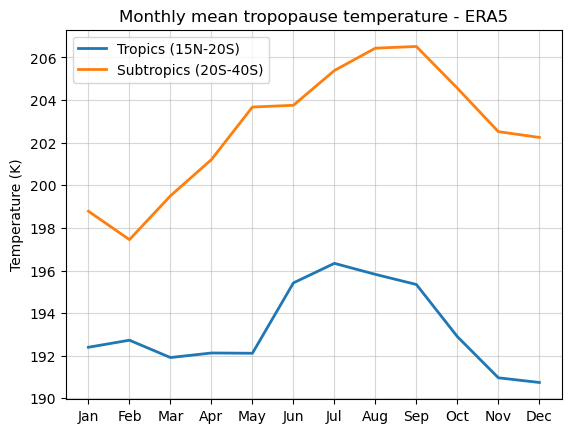

In [38]:
plt.plot(trop_temp_tropics, label='Tropics (15N-20S)',linewidth=2)
plt.plot(trop_temp_subtropics, label='Subtropics (20S-40S)',linewidth=2)
plt.title('Monthly mean tropopause temperature - ERA5')
plt.xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Temperature (K)')
plt.legend(loc='best')
plt.grid(alpha=0.5)

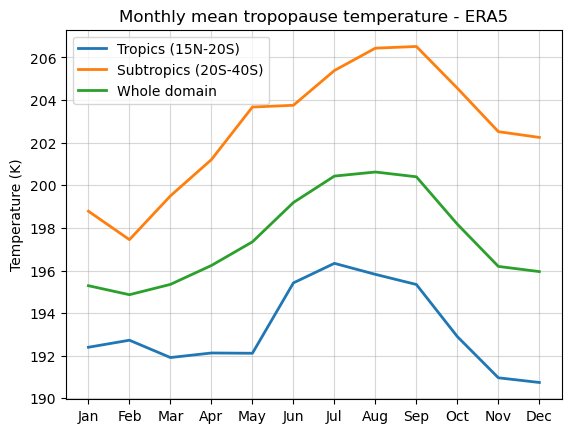

In [39]:
plt.plot(trop_temp_tropics, label='Tropics (15N-20S)',linewidth=2)
plt.plot(trop_temp_subtropics, label='Subtropics (20S-40S)',linewidth=2)
plt.plot(trop_temp, label='Whole domain', linewidth=2)
plt.title('Monthly mean tropopause temperature - ERA5')
plt.xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Temperature (K)')
plt.legend(loc='best')
plt.grid(alpha=0.5)

In [40]:
filename = '/data/users/hgilmour/tb/regridded/regridded_tb_2001.nc'

tb_2001 = xr.open_dataset(filename)

tb_2001 = tb_2001.toa_outgoing_longwave_flux

In [41]:
tb_2001

<xarray.DataArray 'toa_outgoing_longwave_flux' (time: 8760, latitude: 550,
                                                longitude: 600)>
[2890800000 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2001-01-01T00:30:00 ... 2001-12-31T23:30:00
  * latitude   (latitude) float64 -39.95 -39.85 -39.75 ... 14.75 14.85 14.95
  * longitude  (longitude) float64 -89.95 -89.85 -89.75 ... -30.25 -30.15 -30.05
Attributes:
    standard_name:    toa_outgoing_longwave_flux
    units:            K
    um_stash_source:  m01s03i332
    cell_methods:     time: mean (interval: 1 hour)
    grid_mapping:     latitude_longitude

In [42]:
min_temp = []

for month in range(1,13):
    print(month)
    subset = tb_2001[tb_2001.time.dt.month == month]
    #temp = subset.where(subset == subset.min(), drop=True).squeeze().data
    temp = subset[0,:,:].min().squeeze().data
    print(subset[0,:,:].time)
    min_temp.append(int(temp))

1
<xarray.DataArray 'time' ()>
array('2001-01-01T00:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2001-01-01T00:30:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
2
<xarray.DataArray 'time' ()>
array('2001-02-01T00:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2001-02-01T00:30:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
3
<xarray.DataArray 'time' ()>
array('2001-03-01T00:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2001-03-01T00:30:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
4
<xarray.DataArray 'time' ()>
array('2001-04-01T00:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2001-04-01T00:30:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
5
<xarray.DataArray 'tim

In [43]:
min_temp

[186, 188, 186, 186, 189, 191, 189, 195, 190, 193, 186, 189]

In [44]:
### Now for just tropics ##
tropics_tb = tb_2001[:,250:,:]
subtropics_tb = tb_2001[:,:250,:]

In [45]:
min_temp_tropics = []

for month in range(1,13):
    print(month)
    subset = tropics_tb[tropics_tb.time.dt.month == month]
    #temp = subset.where(subset == subset.min(), drop=True).squeeze().data
    temp = subset[0,:,:].min().squeeze().data
    print(subset[0,:,:].time)
    min_temp_tropics.append(int(temp))

1
<xarray.DataArray 'time' ()>
array('2001-01-01T00:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2001-01-01T00:30:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
2
<xarray.DataArray 'time' ()>
array('2001-02-01T00:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2001-02-01T00:30:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
3
<xarray.DataArray 'time' ()>
array('2001-03-01T00:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2001-03-01T00:30:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
4
<xarray.DataArray 'time' ()>
array('2001-04-01T00:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2001-04-01T00:30:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
5
<xarray.DataArray 'tim

In [46]:
min_temp_subtropics = []

for month in range(1,13):
    print(month)
    subset = subtropics_tb[subtropics_tb.time.dt.month == month]
    #temp = subset.where(subset == subset.min(), drop=True).squeeze().data
    temp = subset[0,:,:].min().squeeze().data
    print(subset[0,:,:].time)
    min_temp_subtropics.append(int(temp))

1
<xarray.DataArray 'time' ()>
array('2001-01-01T00:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2001-01-01T00:30:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
2
<xarray.DataArray 'time' ()>
array('2001-02-01T00:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2001-02-01T00:30:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
3
<xarray.DataArray 'time' ()>
array('2001-03-01T00:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2001-03-01T00:30:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
4
<xarray.DataArray 'time' ()>
array('2001-04-01T00:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2001-04-01T00:30:00
Attributes:
    axis:           T
    bounds:         time_bnds
    standard_name:  time
5
<xarray.DataArray 'tim

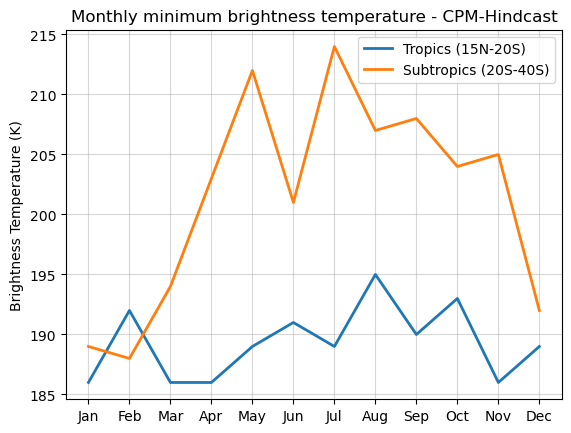

In [47]:
plt.plot(min_temp_tropics, label='Tropics (15N-20S)',linewidth=2)
plt.plot(min_temp_subtropics, label='Subtropics (20S-40S)',linewidth=2)
#plt.plot(min_temp, label='Whole domain', linewidth=2)
plt.title('Monthly minimum brightness temperature - CPM-Hindcast')
plt.xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Brightness Temperature (K)')
plt.legend(loc='best')
plt.grid(alpha=0.5)

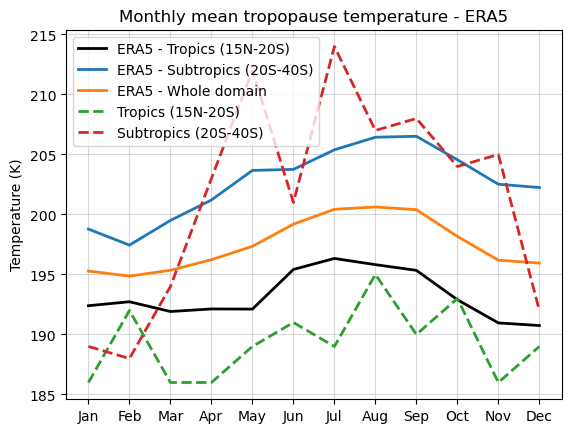

In [51]:
plt.plot(trop_temp_tropics, label='ERA5 - Tropics (15N-20S)',linewidth=2, color='k')
plt.plot(trop_temp_subtropics, label='ERA5 - Subtropics (20S-40S)',linewidth=2)
plt.plot(trop_temp, label='ERA5 - Whole domain', linewidth=2)
plt.plot(min_temp_tropics, label='Tropics (15N-20S)',linewidth=2, linestyle='dashed')
plt.plot(min_temp_subtropics, label='Subtropics (20S-40S)',linewidth=2, linestyle='dashed')
plt.title('Monthly mean tropopause temperature - ERA5')
plt.xticks(np.arange(0,12),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Temperature (K)')
plt.legend(loc='best')
plt.grid(alpha=0.5)